In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/.virtualenvs/nca/bin/python3


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

2024-06-03 20:03:28.374695: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


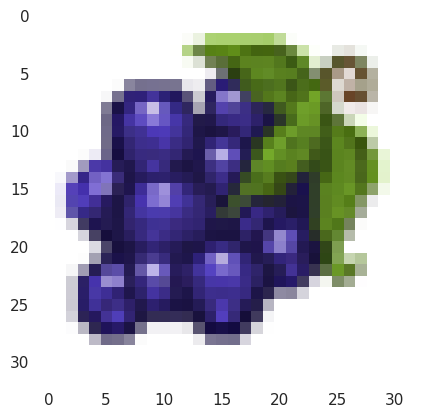

In [4]:
from PIL import Image 
img = Image.open("../img.jpg") 
img = img.resize((32, 32))
img = np.array(img)
img = img/255.
img = jnp.array(img.astype(np.float32))
plt.imshow(img)
plt.grid(False)

In [59]:
class NCAOriginal(nn.Module):
    @nn.compact
    def __call__(self, x):
        H, W, D_in = x.shape
        assert D_in==16
        x = nn.Conv(features=16*3, kernel_size=(3, 3), feature_group_count=16, use_bias=False)(x)
        x = nn.Conv(features=128, kernel_size=(1, 1))(x)  # 1x1 conv or KxK conv?
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(1, 1), kernel_init=nn.initializers.zeros_init())(x)  # 1x1 conv or KxK conv?
        return x

In [60]:
rng = jax.random.PRNGKey(0)
H, W, D = 32, 32, 16
T = 64
nca = NCAOriginal()

def get_video(_rng, params):
    x = jnp.ones((H, W, D))
    x = x.at[H//2, W//2, :].set(0.)
    def forward_step(x, _rng):
        dx = nca.apply(params, x)
        x = x + dx*1e-2
        return x, x[..., :3]
    x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
    return vid
    
def show_video(vid):
    vid = np.clip(vid, 0, 1)
    vid = [vid[i] for i in [0, 16, 32, 48, 63]]
    vid = rearrange(vid, "(R C) H W D -> (R H) (C W) D", R=1)
    plt.imshow(vid)
    plt.grid(False)
    plt.show()

In [61]:
@jax.jit
def train_step(train_state, _rng):
    def loss_fn(params):
        vid = jax.vmap(get_video, in_axes=(0, None))(split(_rng, bs), params)
        pred = vid[:, -1, :, :, :3]
        loss = ((pred-img)**2).mean()
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss

In [62]:
x = jax.random.normal(rng, (H, W, D))
params = nca.init(rng, x)
print(jax.tree.map(lambda x: x.shape, params))

# tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
tx = optax.chain(optax.adamw(2e-3, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=nca.apply, params=params, tx=tx)
bs = 1

{'params': {'Conv_0': {'kernel': (3, 3, 1, 48)}, 'Conv_1': {'bias': (128,), 'kernel': (1, 1, 48, 128)}, 'Conv_2': {'bias': (16,), 'kernel': (1, 1, 128, 16)}}}


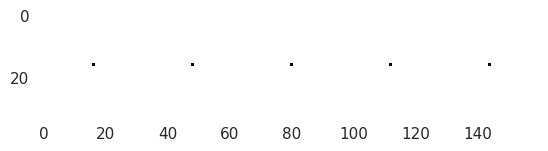

In [63]:
vid = get_video(rng, train_state.params)
show_video(vid)

  0%|          | 0/20001 [00:00<?, ?it/s]

[0.26075405]


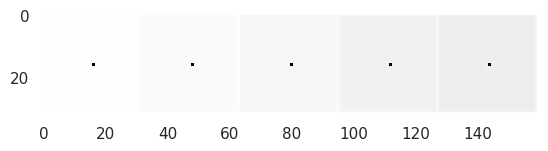

[0.00619758]


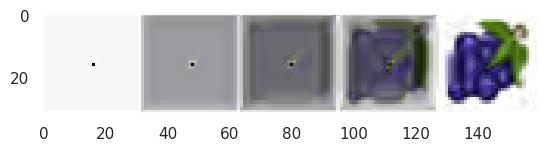

[0.00401952]


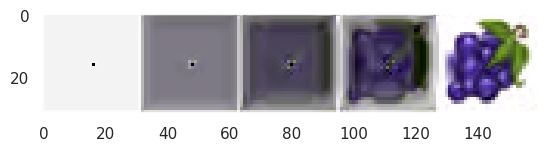

[0.00178233]


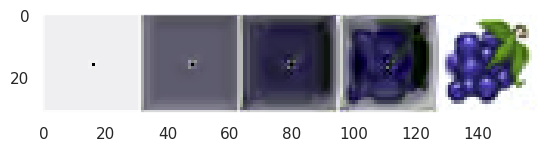

[0.00243772]


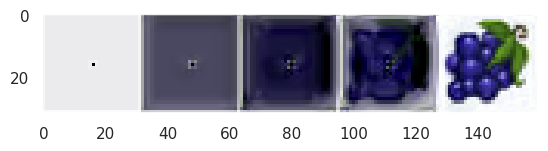

[0.00062674]


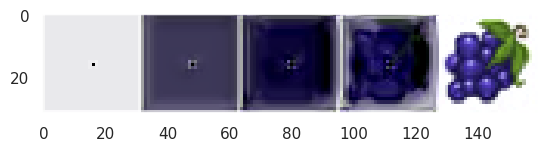

In [64]:
losses = []
pbar = tqdm(range(20000+1))
for i in pbar:
    train_state, loss = jax.lax.scan(train_step, train_state, split(rng, 1))
    losses.extend(loss.tolist())
    pbar.set_postfix(log10_loss=np.log10(losses[-1]))
    if i%4000==0:
        print(loss)
        vid = get_video(rng, train_state.params)
        show_video(vid)

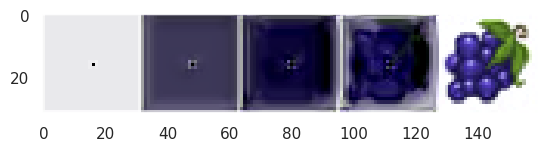

In [65]:
vid = get_video(rng, train_state.params)
show_video(vid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021198323..1.0661352].


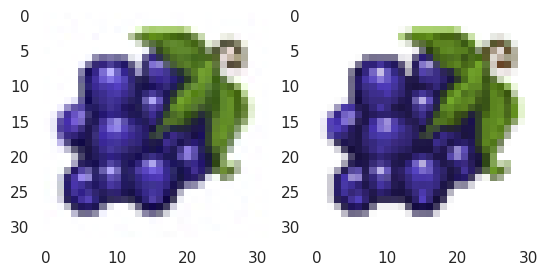

In [66]:
plt.subplot(121)
plt.imshow(vid[-1, ..., :3])
plt.grid(False)
plt.subplot(122)
plt.imshow(img)
plt.grid(False)

In [67]:
df = pd.DataFrame(dict(step=np.arange(len(losses)), loss=losses))
df['loss_smooth'] = df['loss'].ewm(span=500).mean()
df

,step,loss,loss_smooth
0,0,0.260754,0.260754
1,1,0.216557,0.238612
2,2,0.174778,0.217249
3,3,0.140199,0.197871
4,4,0.122359,0.182647
...,...,...,...
19996,19996,0.000497,0.000871
19997,19997,0.000528,0.000870
19998,19998,0.000561,0.000869
19999,19999,0.000592,0.000868


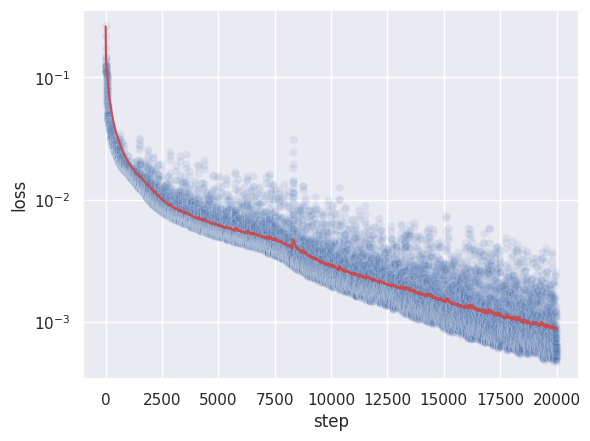

In [68]:
sns.scatterplot(data=df, x='step', y='loss', alpha=0.1)
sns.lineplot(data=df, x='step', y='loss_smooth', c='r')
plt.yscale('log')

In [69]:
sum([p.size for p in jax.tree.flatten(params)[0]])

8768

In [113]:
class NCA(nn.Module):
    n_layers: int
    d_state: int
    d_embd: int
    kernel_size: int = 3
    nonlin: str = 'gelu'

    def setup(self):
        layers = []
        for _ in range(self.n_layers):
            layers.extend([
                nn.Conv(features=self.d_embd, kernel_size=(self.kernel_size, self.kernel_size), feature_group_count=1),
                nn.LayerNorm(),
                getattr(nn, self.nonlin),
            ])
        layers.append(nn.Conv(features=self.d_state, kernel_size=(self.kernel_size, self.kernel_size)))
        self.dynamics_net = nn.Sequential(layers)
        self.obs_net = nn.Conv(features=3, kernel_size=(1, 1))
    
    def forward_dynamics(self, state):
        return self.dynamics_net(state)
        
    def forward_obs(self, state):
        return self.obs_net(state)
        
    def __call__(self, state):
        ds, obs = self.dynamics_net(state), self.obs_net(state)
        return ds, obs



In [114]:
rng = jax.random.PRNGKey(0)
H, W, D = 32, 32, 16
T = 64
nca = NCA(n_layers=1, d_state=16, d_embd=16*4)

def get_video(_rng, params):
    x = jnp.ones((H, W, D))
    x = x.at[H//2, W//2, :].set(-1.)
    x = x/jnp.linalg.norm(x, axis=-1, keepdims=True)
    def forward_step(x, _rng):
        dx = nca.apply(params, x, method=nca.forward_dynamics)
        x = x + dx*1e-2
        x = x/jnp.linalg.norm(x, axis=-1, keepdims=True)
        obs = nca.apply(params, x, method=nca.forward_obs)
        return x, obs
    x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
    return vid
    
def show_video(vid):
    vid = np.clip(vid, 0, 1)
    vid = [vid[i] for i in [0, 16, 32, 48, 63]]
    vid = rearrange(vid, "(R C) H W D -> (R H) (C W) D", R=1)
    plt.imshow(vid)
    plt.grid(False)
    plt.show()

In [102]:
x = jax.random.normal(rng, (H, W, D))
params = nca.init(rng, x)
print(jax.tree.map(lambda x: x.shape, params))

# tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
tx = optax.chain(optax.adamw(2e-3, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=nca.apply, params=params, tx=tx)
bs = 1

{'params': {'dynamics_net': {'layers_0': {'bias': (64,), 'kernel': (3, 3, 16, 64)}, 'layers_1': {'bias': (64,), 'scale': (64,)}, 'layers_3': {'bias': (16,), 'kernel': (3, 3, 64, 16)}}, 'obs_net': {'bias': (3,), 'kernel': (1, 1, 16, 3)}}}


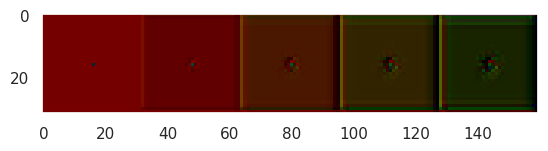

In [106]:
vid = get_video(rng, params)
show_video(vid)

  0%|          | 0/20001 [00:00<?, ?it/s]

[0.50099653]


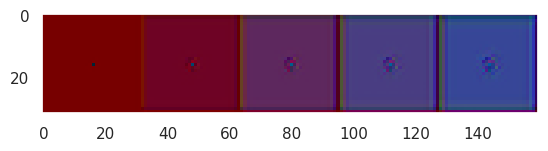

[0.00043962]


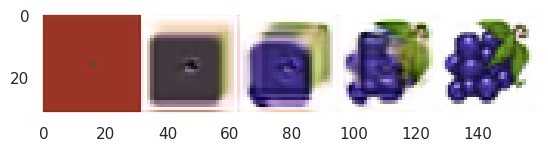

[0.0002118]


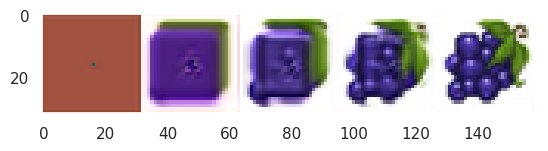

[0.00020514]


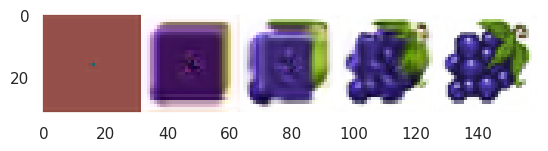

[0.00019568]


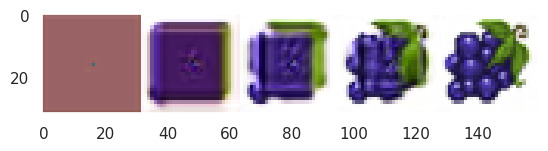

[3.1807147e-05]


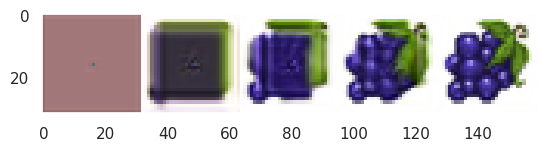

In [107]:
losses = []
pbar = tqdm(range(20000+1))
for i in pbar:
    train_state, loss = jax.lax.scan(train_step, train_state, split(rng, 1))
    losses.extend(loss.tolist())
    pbar.set_postfix(log10_loss=np.log10(losses[-1]))
    if i%4000==0:
        print(loss)
        vid = get_video(rng, train_state.params)
        show_video(vid)

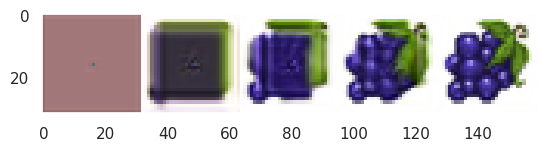

In [108]:
vid = get_video(rng, train_state.params)
show_video(vid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.046657294..1.0143201].


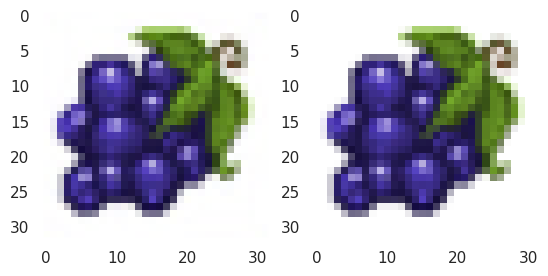

In [109]:
plt.subplot(121)
plt.imshow(vid[-1, ..., :3])
plt.grid(False)
plt.subplot(122)
plt.imshow(img)
plt.grid(False)

In [110]:
df = pd.DataFrame(dict(step=np.arange(len(losses)), loss=losses))
df['loss_smooth'] = df['loss'].ewm(span=500).mean()
df

,step,loss,loss_smooth
0,0,0.500997,0.500997
1,1,0.256966,0.378737
2,2,0.205646,0.320809
3,3,0.179682,0.285315
4,4,0.164587,0.260976
...,...,...,...
19996,19996,0.000034,0.000065
19997,19997,0.000032,0.000065
19998,19998,0.000032,0.000065
19999,19999,0.000033,0.000065


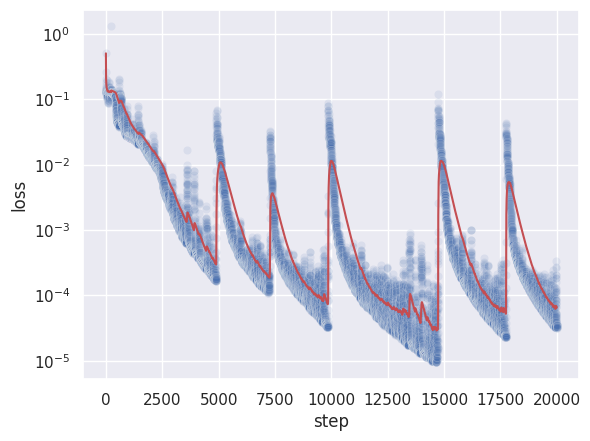

In [111]:
sns.scatterplot(data=df, x='step', y='loss', alpha=0.1)
sns.lineplot(data=df, x='step', y='loss_smooth', c='r')
plt.yscale('log')

In [112]:
sum([p.size for p in jax.tree.flatten(params)[0]])

18691

In [ ]:
# x' = x+f1(x)
# x'' = x+f1(x)+f1(x+f1(x))

# x' = x+f1(x)+f2(x)
# x'' = x+f1(x)+f2(x) + f1(x+f1(x)+f2(x)) + f2(x+f1(x)+f2(x))

In [41]:
16*16*3*3

2304

In [42]:
16*16*4*2

2048

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 16)


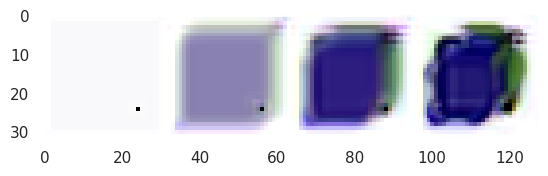

In [131]:
def get_video(_rng, params):
    x = jnp.ones((H, W, D))
    # x = x.at[:, :, :3].set(img)
    x = x.at[H//2+8, W//2+8, :].set(0.)
    x = x.at[H, W, :].set(0.)
    def forward_step(x, _rng):
        x = nca.apply(params, _rng, x)
        return x, x
    x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
    return vid


vid = get_video(rng, train_state.params)
print(vid.shape)
plt.imshow(rearrange(vid[::16, ..., :3], "(R C) H W D -> (R H) (C W) D", R=1))
plt.grid(False)

In [4]:
# random NCAs

In [70]:
class NCA(nn.Module):
    n_layers: int
    d_embd: int
    kernel_size: int = 3
    nonlin: str = 'gelu'
    p_drop: float = 0.0
    
    @nn.compact
    def __call__(self, _rng, xin):
        H, W, D_in = xin.shape
        x = xin
        for _ in range(self.n_layers):
            x = nn.Conv(features=self.d_embd, kernel_size=(self.kernel_size, self.kernel_size))(x)
            # x = nn.LayerNorm()(x)
            x = getattr(nn, self.nonlin)(x)
            # x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        # x = nn.Conv(features=D_in, kernel_size=(kernel_size, kernel_size))(x)
        x = nn.Conv(features=D_in, kernel_size=(1, 1))(x)
        x = x*1e-2
        mask = 1-(jax.random.uniform(_rng, (H, W)) < self.p_drop)
        x = xin + x * mask[:, :, None]
        # return jnp.clip(x, min=-2, max=2)
        return x/jnp.linalg.norm(x, axis=-1, keepdims=True)


In [71]:
rng = jax.random.PRNGKey(0)
H, W, D = 128, 128, 64
T = 64
nca = NCA(n_layers=2, d_embd=64)

x = jax.random.normal(rng, (H, W, D))
params = nca.init(rng, rng, x)

# def get_video(_rng, params):
#     x = jax.random.normal(_rng, (256, 256))
#     def forward_step(x, _rng):
#         x = nca.apply(params, _rng, x)
#         return x, x
#     x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
#     return vid

In [72]:
forward_fn = jax.jit(nca.apply)
for _ in tqdm(range(100000)):
    x = forward_fn(params, rng, x)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
x = forward_fn(params, rng, x)

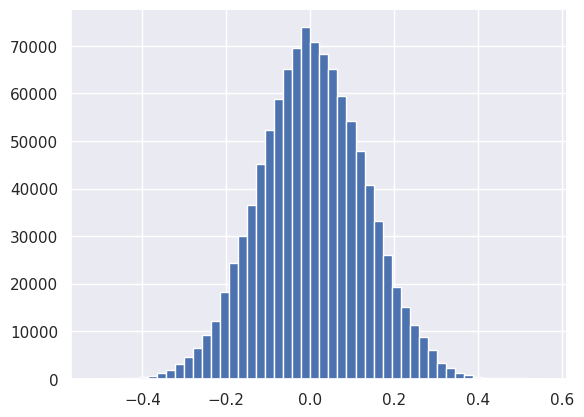

In [73]:
plt.hist(x.flatten(), bins=50);